In [1]:
!unzip -o .data/*.zip -d .data

Archive:  .data/drive-download-20210519T172133Z-001.zip
  inflating: .data/2021_05_19 20_03 Office Lens.jpg  
  inflating: .data/IMG_20210519_200224.jpg  
  inflating: .data/IMG_20210519_200214.jpg  
  inflating: .data/IMG_20210519_200158.jpg  
  inflating: .data/IMG_20210519_200151.jpg  
  inflating: .data/IMG_20210519_200206.jpg  
  inflating: .data/IMG_20210519_200147.jpg  
  inflating: .data/IMG_20210519_200231.jpg  


In [2]:
!ls .data

'2021_05_19 20_03 Office Lens.jpg'	   IMG_20210519_200206.jpg
 drive-download-20210519T172133Z-001.zip   IMG_20210519_200214.jpg
 IMG_20210519_200147.jpg		   IMG_20210519_200224.jpg
 IMG_20210519_200151.jpg		   IMG_20210519_200224.jpg2
 IMG_20210519_200158.jpg		   IMG_20210519_200231.jpg


In [3]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision

torch.__version__

'1.7.0+cu101'

In [4]:
def load_images(path):
    file_names = [f for f in os.listdir(path) if f.endswith('jpg')]
    imgs = []
    scale = 0.1
    h, w = int(2997 * scale), int(2138 * scale)
    for file_name in file_names:
        im_path = os.path.join(path, file_name)
        img = cv2.imread(im_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (w, h))
        imgs.append(img / 255)
        
    return torch.tensor(imgs, dtype=torch.float32)

In [5]:
imgs = load_images('.data')

In [6]:
y = imgs[1]
x = imgs[4]

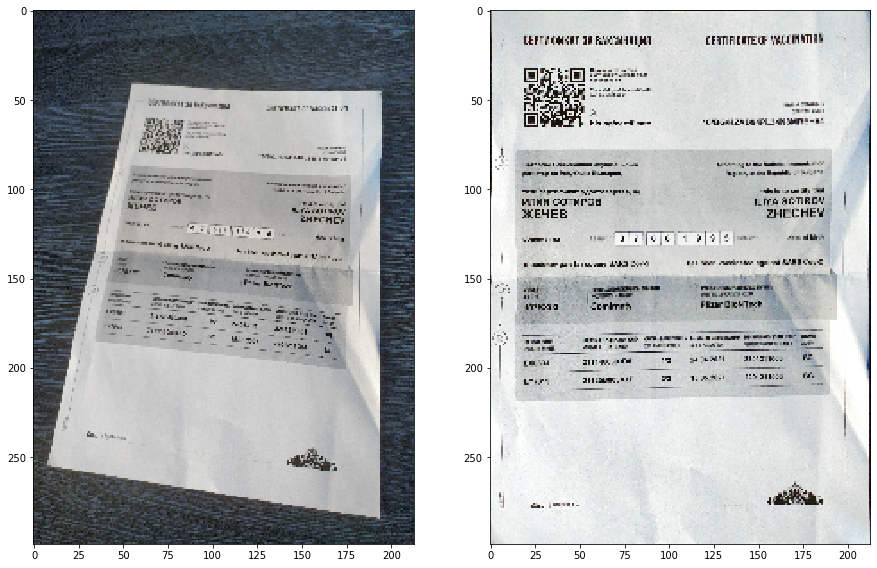

In [7]:
fig = plt.figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(1, 2)

ax1.imshow(x)
ax2.imshow(y)

In [8]:
x.shape

torch.Size([299, 213, 3])

In [9]:
class Reshape(nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.reshape(self.shape)

In [10]:
class Lambda(nn.Module):
    def __init__(self, handler):
        super().__init__()
        self.handler = handler

    def forward(self, x):
        return self.handler(x)

In [52]:
class SpatialTransformer(nn.Module):
    def __init__(self, i, num_channels, only_translations=False):
        super().__init__()

        self.only_translations = only_translations
        self.num_channels = num_channels
        self.locator = nn.Sequential(
            nn.Linear(i, num_channels * 2 * 3),
            Reshape(-1, 2, 3),
        )

        self.device = self.locator[0].bias.device
        # Taken from the pytorch spatial transformer tutorial.
        self.locator[0].weight.data.zero_()
        self.locator[0].bias.data.copy_(
            torch.tensor(
                [1, 0, 0, 0, 1, 0] * num_channels,
                dtype=torch.float,
            ).to(self.device))

    def forward(self, x):
        inp, tensor_3d = x
        device = inp.device

        theta = self.locator(inp)
        _, C, H, W, = tensor_3d.shape

        if self.only_translations:
            theta[:, :, :-1] = torch.tensor(
                [[1, 0], [0, 1]],
                dtype=torch.float,
            ).to(device).unsqueeze_(0)

        grid = F.affine_grid(
            theta,
            (theta.size(dim=0), 1, H, W),
            align_corners=True,
        )

        tensor_3d = tensor_3d.reshape(-1, 1, H, W)
        tensor_3d = F.grid_sample(
            tensor_3d,
            grid,
            align_corners=False,
            mode='bilinear'
        )

        return tensor_3d.reshape(-1, C, H, W)

In [59]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = Lambda(lambda x: x.permute(2, 0, 1).unsqueeze(0))
        self.feature_extractor = torchvision.models.resnet50(pretrained=True)
        self.st = SpatialTransformer(1000, num_channels=1)
        self.loss_hist = []
        
    def forward(self, x):
        x = self.norm(x)
        self.features = self.feature_extractor(x)
        y_hat = self.st([self.features, x[:, :1]])
        return y_hat
    
    def criterion(self, y_hat, y):
        y = self.norm(y)[:, :1]
        return F.binary_cross_entropy(y_hat, y)
    
    def optim_step(self, optim, batch):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        
        if loss.requires_grad:
            optim.zero_grad()
            loss.backward()
            optim.step()
            
        self.loss_hist.append(loss.item())
            
        return {
            'loss': loss.item(),
            'features': self.features,
            'y_hat': y_hat,
        }

In [60]:
from IPython.display import display, clear_output

class Fig:
    def __init__(self, nr, nc, *args, **kwargs):
        self.fig = plt.figure(*args, **kwargs)
        self.axs = self.fig.subplots(nr, nc)
        self.called = set()
        plt.close()
    
    def __getitem__(self, index):
        ax = self.axs[index] if hasattr(self.axs, '__getitem__') else self.axs

        class Getattr:
            def __getattr__(_, identifier):
                if identifier == 'ax':
                    return ax

                key = identifier, index

                class Call:
                    def __call__(_, data, **kwargs):
                        def set_data(child):
                            try:
                                child.set_array(data.ravel())
                                return True
                            except:
                                try:
                                    child.set_data(data)
                                    return True
                                except Exception as e:
                                    return False

                        def create_plot():
                            self.called.add(key)
                            try:
                                getattr(sns, identifier)(data, **kwargs, ax=ax)
                            except:
                                try:
                                    getattr(ax, identifier)(data, **kwargs)
                                except Exception as e:
                                    raise e

                        if key in self.called:
                            found = False
                            for child in ax.get_children():
                                success = set_data(child)
                                if success:
                                    found = True
                            if not found:
                                ax.clear()
                                create_plot()
                        else:
                            create_plot()

                return Call()

        return Getattr()
    
    def display(self):
        display(self.fig)
        return self
        
    def clear(self):
        clear_output(wait=True)
        return self
        
    def update(self):
        self.clear()
        self.display()

In [61]:
from threading import Thread
import time
mem = {}
ctx = {}

def in_para(func):
    def thread_handler():
        try:
            func(ctx)
        except Exception as e:
            print(e)
        
    func_name = func.__name__
    
    if func_name not in mem or not mem[func_name].is_alive():
        t = Thread(target=thread_handler)
        mem[func_name] = t
        t.start()
    else:
        # thread is already running
        pass

---

In [62]:
# t = next(model.feature_extractor.parameters())
# t.requires_grad

In [63]:
# for param in model.parameters():
#     param.requires_grad = True

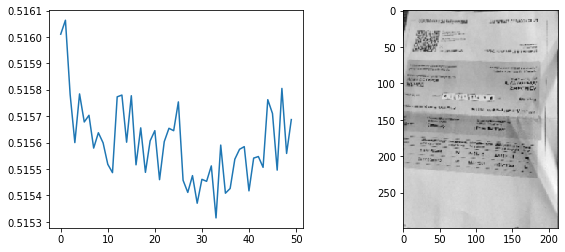

In [ ]:
DEVICE = 'cuda'

model = Model()
model = model.to(DEVICE)

optim = torch.optim.Adam(model.parameters(), lr=0.00001)
f = Fig(1, 2, figsize=(10, 4))

tq = tqdm(range(5000), disable=False)
for i in tq:
    optim_info = model.optim_step(optim, [x.to(DEVICE), y.to(DEVICE)])
    features = optim_info['features'].detach().cpu()[0, :200]
    img = optim_info['y_hat'].detach().cpu()[0, 0]
    loss = optim_info['loss']
    tq.set_description(f'Loss: {loss}')

    if i % 500 == 0:
        f[0].plot(model.loss_hist[-50:])
        f[1].imshow(img, cmap='binary_r')
        f.update()
